In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

master_dir = os.getcwd()

In [2]:
# get data with patient name, label and additional data
meta_data_path = os.path.join(master_dir,'MTBLS315')
meta_file = "s_NMFI and BSI diagnosis.txt"
meta_data = pd.read_csv(os.path.join(meta_data_path, meta_file), sep='\t')
meta_data = meta_data[['Sample Name', 'Factor Value[patient group]','Factor Value[severe malnutrition]', 
                      'Factor Value[prior antimalaria treatment]','Factor Value[prior antibiotic treatment]']]
# get data with patient name to sample name and rename columns
patient_to_sample = pd.read_csv(os.path.join(meta_data_path, 'combined_name_to_data.txt'), sep=' ')
patient_to_sample.rename(columns={'Sample': 'Sample Name'}, inplace=True)
meta_data = meta_data.merge(patient_to_sample, on='Sample Name')
meta_data.rename(columns={'Sample': 'Sample Name',
                          'Factor Value[patient group]':'label', 
                          'Factor Value[severe malnutrition]':'malnutrition', 
                          'Factor Value[prior antimalaria treatment]':'prior_antimal_treat',
                          'Factor Value[prior antibiotic treatment]':'prior_antibio_treat',
                          'Name':'mzML_p', 'Spectral':'mzXML_p', 'File':'cdf', 'Name.1':'mzML_n'
                         }, inplace=True)
meta_data.label[meta_data.label == 'bacterial bloodstream infection'] = 0 
meta_data.label[meta_data.label == 'non-malarial febrile illness'] = 0
meta_data.label[meta_data.label == 'malaria'] = 1
meta_data[meta_data == 'yes'] = 1
meta_data[meta_data == 'no'] = 0
#rename the row indicies so you acn sort the rows to match with the features
names = list(meta_data.mzXML_p) 
renames = {ind:name for ind,name in zip(list(meta_data.index.values),names)}
meta_data = meta_data.rename(index=renames)
index_order = sorted(names) # order to be used when sorting the rows of the later dataframes to map the labels and metadata
meta_data = meta_data.reindex(index_order)

# this is the mzXML file with the author feature intensities
file = os.path.join(meta_data_path,'m_nmfi_and_bsi_diagnosis_metabolite_profiling_mass_spectrometry-1_v2_maf.tsv')
m_d = pd.read_csv(file, sep='\t')
# DO NOT USE THE FOLLOWING FILE: it has duplicates for each possible compound with the same mass
# file = os.path.join(meta_data_path,'m_LC_nmfi_and_bsi_diagnosis_v2_maf.tsv')
# m_d = pd.read_csv(file, sep='\t')
m_d = m_d.iloc[:,21:].T
index_order = sorted(m_d.index.values)
m_d = m_d.reindex(index_order)

# load in the various data (currently different xcms minfrac trials)
data_path = "MTBLS315/data/mzXML_csv"
working_dir = os.path.join(master_dir,data_path)
csv_files = os.listdir(working_dir)
file_names = [ele[12:-12] for ele in csv_files]
# print('File names: ', file_names)
full_data = {}
for name, file in zip(file_names, csv_files):
    file = os.path.join(working_dir, file)
    full_data[name] = pd.read_csv(file)
# sort datasets to be in same format as the label portion / metadata
features = {}
for dataset in full_data:
    index_order = sorted(list(full_data[dataset].iloc[:,9:-3])) #gets the names of the data files and sorts them
    features[dataset] = full_data[dataset].iloc[:,9:-3].T.reindex(index_order)
    # Now we have the metadata rows matching the feature rows...now combine dataframes to give labels / covariates to data

    
# add the author features to the features dictionary of datasets:
features['author'] = m_d
    
# take the malnutrition, prior_antimal_treat, prior_antibio_treat and label columns from meta_data and add to features
to_add = ['malnutrition', 'prior_antimal_treat', 'prior_antibio_treat', 'label']
for dataset in features:
    for feature in to_add:
        features[dataset][feature] = meta_data[feature].values
    print(dataset, features[dataset].shape)
    
# NOTE: features is the main dictionary with all datasets with intensities + covariates + labels

20Pminfrac (61, 3413)
30Pminfrac (61, 2744)
40Pminfrac (61, 2333)
10Pminfrac (61, 4502)
5Pminfrac (61, 5415)
100Pminfrac (61, 303)
0Pminfrac (61, 9551)
author (61, 558)


Function used to discover significant features (p<0.05 With a 5% FDR correction using H-B)

In [3]:
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

def fdr_corrected_p(data, type='MN_U'):
    '''
    NOTE: if one class is all nan then it will give a p=0 for that row if these are not removed first
    input:
        data - pd data frame (assumes the labels (ie Ys) are in the last column of the df with the title 'label')
        type - Mann-Whitney U test (MN_U) or Kruskal-Wallis (KW)
    output:
        FDR corrected P-values for each of the features
    '''
    assert type == 'MN_U' or type == 'KW', 'Please input MN_U if two samples, or KW with 3+ - default is MN_U'

    if type == 'MN_U':
        test = mannwhitneyu
        X_0 = data[data.label==0].iloc[:,:-1]
        X_1 = data[data.label==1].iloc[:,:-1]
    elif type == 'KW':
        test = kruskal
        print('kruskal test not currently available')
        return 0
    else:
        return 0
    
    p = np.zeros((X_0.shape[1],1)) + np.nan
    for i in range(X_0.shape[1]):
        try:
            X0 = X_0.iloc[:,i]
            X0.dropna(inplace=True)
            X1 = X_1.iloc[:,i]
            X1.dropna(inplace=True)
            _, p[i] = test(X0, X1, alternative='two-sided')
        except:
            print('Found an unknown exception, passing!')
            pass
    # do the FDR correction
    _, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=0.05, method='fdr_bh')
    return p.T

def find_num_sig_p(p):
    return p[p<0.05]

# get corrected p values for all datasets
dataset_p = {}
log2 = False # do significance testing on the log2 transformed data?
for dataset in features:
    if log2:
        features[dataset].iloc[:,:-4] = np.log2(features[dataset].iloc[:,:-4])
#     data_mat = np.asarray(data_mat, dtype=float)
#     data_mat = np.log2(data_mat)
    dataset_p[dataset] = fdr_corrected_p(features[dataset])

/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [4]:
for d_ps in dataset_p:
#     if d_ps == '100Pminfrac':
#     print(dataset_p[d_ps])
    print('size of the data set: ', dataset_p[d_ps].shape)
    print(d_ps, 'number of significant p values - FDR corrected: ', np.where(np.logical_and(dataset_p[d_ps]<0.05, dataset_p[d_ps]>0))[1].shape[0])
    
# print(dataset, find_num_sig_p(dataset_p[dataset]))

size of the data set:  (1, 3412)
20Pminfrac number of significant p values - FDR corrected:  0
size of the data set:  (1, 2743)
30Pminfrac number of significant p values - FDR corrected:  0
size of the data set:  (1, 2332)
40Pminfrac number of significant p values - FDR corrected:  0
size of the data set:  (1, 4501)
10Pminfrac number of significant p values - FDR corrected:  0
size of the data set:  (1, 5414)
5Pminfrac number of significant p values - FDR corrected:  2
size of the data set:  (1, 302)
100Pminfrac number of significant p values - FDR corrected:  15
size of the data set:  (1, 9550)
0Pminfrac number of significant p values - FDR corrected:  156
size of the data set:  (1, 557)
author number of significant p values - FDR corrected:  4


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.multiclass import type_of_target # used to check the Y labels are appropriate for classification

def convert_nan_to_val(data, value=0):
    data[pd.isnull(data)] = value
    return data

def logistic_regression(X, y, seed):
#     print(X)
#     X[:,:-3] = np.log(X[X != 0])
#     print(X)
#     X = StandardScaler().fit_transform(X)
    clf = GridSearchCV(estimator=LogisticRegression(penalty='l1',
                                                    solver='liblinear',
                                                    tol=1e-3,
                                                    intercept_scaling=10, # very large hurts liblinear convergence
                                                    max_iter=500,
                                                    random_state=seed),
                       cv=StratifiedKFold(5, random_state=seed+1),
                       param_grid={'C': 10.**np.linspace(-4,4)},
                       n_jobs=-1,
                       scoring='roc_auc')
    auc = cross_val_score(clf, X, y,
                          scoring='roc_auc',
                          cv=StratifiedKFold(3, random_state=seed+2))
    return auc.mean()


The cell below does log scaling of intensities after filling nan values with 10000

NEED to remove all the isotopes / differently ionized species

In [6]:
# noise is the value that is put in for all the nan values since 0 does not make sense always
noise = 1
seed = 103434

#reminder: features is the dictionary with all data along with 'label' in the last column
# convert data to Xs and Ys that are arrays
# fill in nan values with 0.0
data_sets = {}
for dataset in features:
    data_sets[dataset] = [convert_nan_to_val(features[dataset].values[:,:-1], noise), features[dataset].values[:,-1]]
print('added noise')
#data_sets is a dict with keys of the datasets...'author', '20Pminfrac' etc and values that are lists
# the lists have the first entry as the features and the second as the class label

for dataset in data_sets:
    X = data_sets[dataset][0]
    X = np.asarray(X, dtype=float)
    X[:,:-3] = np.log(X[:,:-3])
    Y = data_sets[dataset][1]
    print(dataset, logistic_regression(X[:,:-3], list(Y), seed=seed))

added noise
20Pminfrac 0.7640291806958474
30Pminfrac 0.7578563411896745
40Pminfrac 0.7704826038159371
10Pminfrac 0.8173400673400674
5Pminfrac 0.8338945005611672
100Pminfrac 0.867564534231201
0Pminfrac 0.8521324354657688
author 0.7595398428731762


In [5]:
print(noise)

1


With data normalization [0-1] for the intensities

In [8]:
from sklearn.preprocessing import normalize

for dataset in data_sets:
    X = data_sets[dataset][0]
    X = np.asarray(X, dtype=float)
    X[:,:-3] = normalize(np.log(X[:,:-3]))
    Y = data_sets[dataset][1]
    print(dataset, logistic_regression(X, list(Y), seed=seed))
#     for i in range(2):
#         print(dataset)
#         plt.plot()
#         plt.subplot((121))
#         plt.hist(list(data_sets[dataset][0][:,i]), bins=50)
#         plt.tight_layout()
        
#         X = data_sets[dataset][0]
#         X = np.asarray(X, dtype=float)
#         X = np.log(X[:,:-3])
#         plt.subplot((122))
#         plt.hist(X[:,i], bins=50)
#         plt.tight_layout()
#         plt.show()
#         Y = data_sets[dataset][1]


20Pminfrac 0.7090347923681257
30Pminfrac 0.690796857463524
40Pminfrac 0.696127946127946
10Pminfrac 0.8179012345679012
5Pminfrac 0.803872053872054
100Pminfrac 0.8016273849607183
0Pminfrac 0.8521324354657688
author 0.818462401795735


With standardization after log transformation

In [246]:
for dataset in data_sets:
    X = data_sets[dataset][0]
    X = np.asarray(X, dtype=float)
    X[:,:-3] = StandardScaler().fit_transform(np.log(X[:,:-3]))
    Y = data_sets[dataset][1]
    print(dataset, logistic_regression(X, list(Y), seed=seed))

20Pminfrac 0.8313692480359146
30Pminfrac 0.8670033670033671
40Pminfrac 0.9163860830527497
10Pminfrac 0.8395061728395062
5Pminfrac 0.8280022446689114
100Pminfrac 0.8894500561167229
0Pminfrac 0.8790684624017957
author 0.7853535353535354


same as above but with just the standardized-log peak areas and NO meta data like prior antibiotic / prior malaria

In [247]:
for dataset in data_sets:
    X = data_sets[dataset][0]
    X = np.asarray(X, dtype=float)
    X[:,:-3] = StandardScaler().fit_transform(np.log(X[:,:-3]))
    Y = data_sets[dataset][1]
    print(dataset, logistic_regression(X[:,:-3], list(Y), seed=seed))

20Pminfrac 0.8221099887766554
30Pminfrac 0.8462401795735129
40Pminfrac 0.9267676767676768
10Pminfrac 0.8482042648709315
5Pminfrac 0.7881593714927048
100Pminfrac 0.8928170594837262
0Pminfrac 0.8535353535353535
author 0.745230078563412


peak areas are standardized but not log transformated first 

In [248]:
for dataset in data_sets:
    X = data_sets[dataset][0]
    X = np.asarray(X, dtype=float)
    X[:,:-3] = StandardScaler().fit_transform(X[:,:-3])
    Y = data_sets[dataset][1]
    print(dataset, logistic_regression(X, list(Y), seed=seed))

20Pminfrac 0.824635241301908
30Pminfrac 0.8417508417508418
40Pminfrac 0.8156565656565657
10Pminfrac 0.8173400673400674
5Pminfrac 0.8338945005611672
100Pminfrac 0.8782267115600448
0Pminfrac 0.7727272727272728
author 0.7721661054994389


Look at the effect of filtering out isotopes from the reprocessed data...

In [ ]:
# need to 'de-isotope'


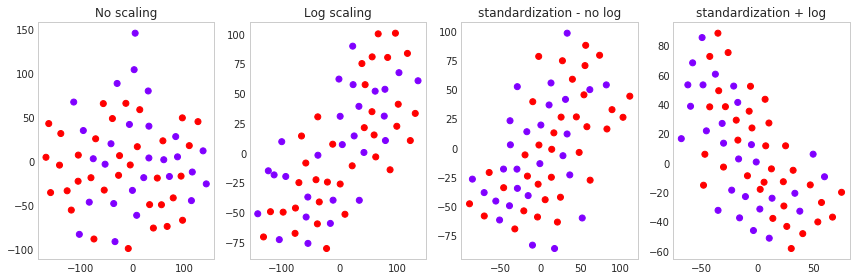

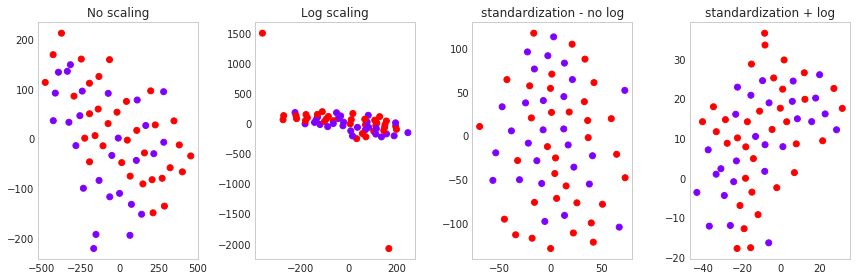

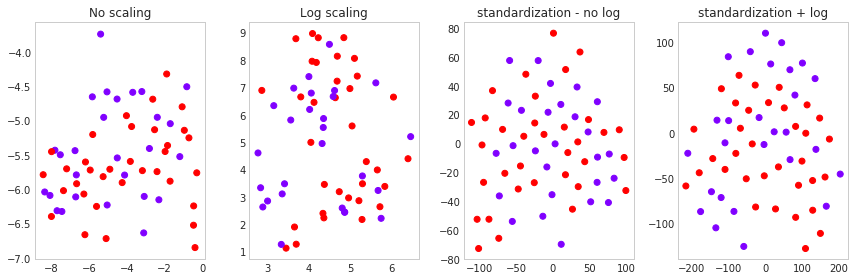

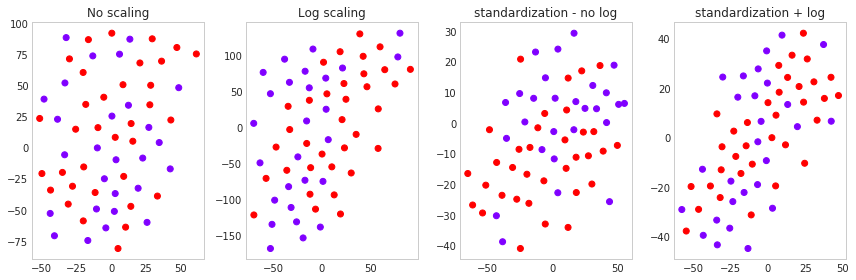

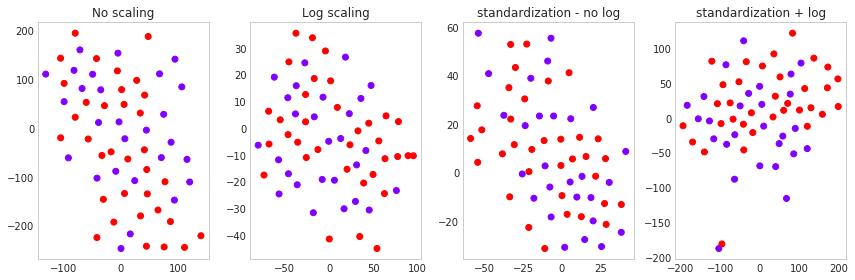

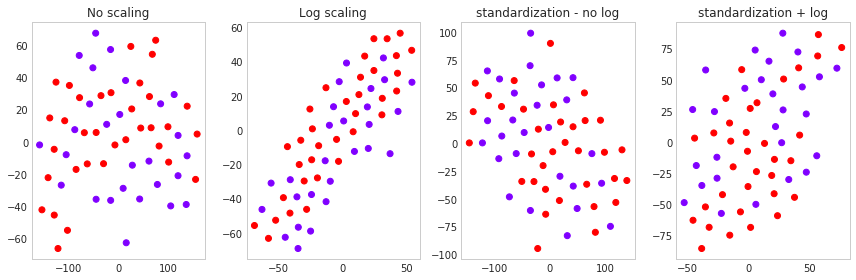

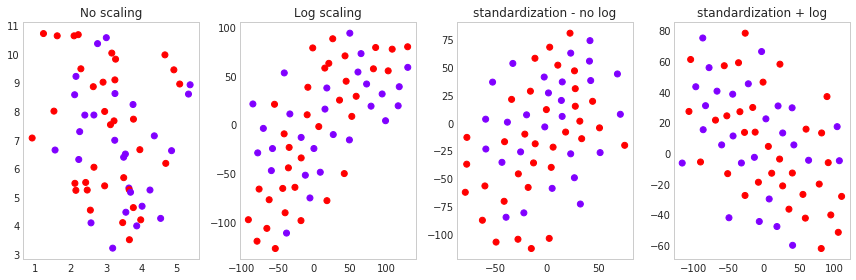

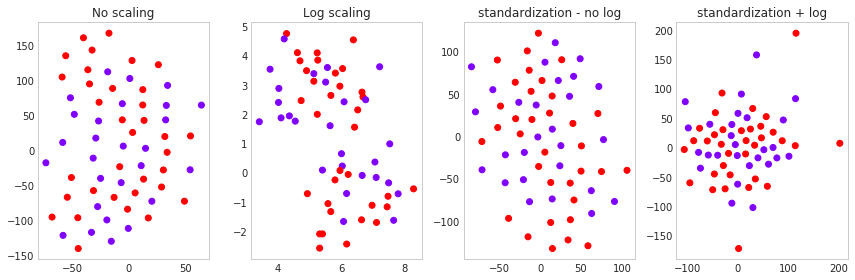

In [267]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

for dataset in data_sets:
    X = data_sets[dataset][0]
    X = np.asarray(X, dtype=float)
    
    plt.figure(figsize=(12,4))
    X_ = PCA(n_components=50).fit_transform(X[:,:-3])
    X_ = TSNE().fit_transform(X_)
    plt.subplot((141))
    plt.title('No scaling')
    plt.scatter(X_[:,0], X_[:,1], c=data_sets[dataset][1], cmap='rainbow')
    
    Z = StandardScaler().fit_transform(X[:,:-3])
    X_ = PCA(n_components=50).fit_transform(Z)
    X_ = TSNE().fit_transform(X_)
    plt.subplot((143))
    plt.title('standardization - no log')
    plt.scatter(X_[:,0], X_[:,1], c=data_sets[dataset][1], cmap='rainbow')
    
    Y = np.log(X[:,:-3])
    X_ = PCA(n_components=50).fit_transform(Y)
    X_ = TSNE().fit_transform(X_)
    plt.subplot((142))
    plt.title('Log scaling')
    plt.scatter(X_[:,0], X_[:,1], c=data_sets[dataset][1], cmap='rainbow')
    
    W = np.log(X[:,:-3])
    W = StandardScaler().fit_transform(W)
    X_ = PCA(n_components=50).fit_transform(W)
    X_ = TSNE().fit_transform(X_)
    plt.subplot((144))
    plt.title('standardization + log')
    plt.scatter(X_[:,0], X_[:,1], c=data_sets[dataset][1], cmap='rainbow')
    
    plt.tight_layout()
    plt.show()
    